This notebook is meant for the CLUSTER version of analysis, for the purposes of creating an entropy profile that mimics the Phoenix cluster and similar clusters that lack an AGN that heats against the cooling flow.

In [34]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
#from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
import lab_functions_1 as lf
from numba import njit
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
etkv = 6.2415*10**8
kevtk = 1.16*10**7
z = 0.597
Mdot1 = 6.30391e25

In [35]:
radii_grid = np.linspace(1*ktc, 16000*ktc, 80000)
vc_grid = np.array([lf.vcgrab(r, z, 3e12, 2e15) for r in radii_grid])
vc_interp = interp1d(radii_grid, vc_grid, kind='cubic', fill_value='extrapolate')

In [36]:
from scipy.integrate import cumulative_trapezoid
r_grid = np.geomspace(ktc*0.01, 10000000 * ktc, 100000)  # finer grid = better accuracy
vc2_over_r = np.array([(lf.vcgrab(r, z, 3e12, 2e15 )**2 / r) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)

In [37]:
print(phi(500*ktc))

-1.3060565096240493e+17


In [38]:
def dlnTdlnrcalc(R_sonic, x, T_sonic_point, Lambdatype, pr=True): 
    if Lambdatype == "W":
        dlnL1 = np.log(lf.Lambdacalc(np.log10(T_sonic_point), R_sonic, "a", 1))
        dlnL2 = np.log(lf.Lambdacalc(np.log10(T_sonic_point*1.01), R_sonic, "a", 1))
    else:
        dlnL1 = np.log(lf.Lambdacalc(np.log10(T_sonic_point), R_sonic, Lambdatype, 1))
        dlnL2 = np.log(lf.Lambdacalc(np.log10(T_sonic_point*1.01), R_sonic, Lambdatype, 1))
    
    dlnT1 = np.log(T_sonic_point)
    dlnT2 = np.log(T_sonic_point*1.01)
    dlnLambda_dlnT = (dlnL2 - dlnL1)/(dlnT2 - dlnT1)


    dlnvc_dlnR = lf.dVcdrfunc(R_sonic, z, 3e12, 2e15)
    
    #solve quadratic equation    
    b = 29/6.*x - 17/6. + 1/3.*(1.-x)*(dlnLambda_dlnT)
    c = 2/3.*x*dlnvc_dlnR + 5*x**2 - 13/3.*x + 2/3.
    if b**2-4*c >= 0:
        return [(-b +j * (b**2-4*c)**0.5)/2. for j in (-1,1)]
    else:
        if pr: print('no transsonic solutions')
        return None, None

In [39]:
@njit
def compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda):
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    tflow = r / abs(v)
    mach2 = v**2 / cs2
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow / (gamma * tcool))) / (mach2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2 / 3) * (2 + dlnvdlnr)

    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr

    return dvdr, dTdr

In [40]:
# THE ODE SOLVER ITSELF
def TheODE(r, C, Mdot, Lambdatype, recorder=None):
    v, T = C
    vc2 = vc_interp(r)**2

    # n is computed inside, so use dummy rho/n for Lambda
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)

    # if T > 10**8.16:
    #     print(T)
    dvdr, dTdr = compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda)

    if recorder is not None:
        recorder["ra2"].append(r)
        recorder["varray"].append(v)
        recorder["Tarray"].append(T)
        recorder["rhoarray"].append(rho)
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)  
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        recorder["Bern"].append(Bern)
        mach = np.sqrt(v**2 / cs2)
        recorder["Mach"].append(mach)
    return [dvdr, dTdr]

In [41]:
# CLASSES (THE BANE OF MY EXISTENCE)
class IntegrationResult:
    def __init__(self, res, stop_reason, xval=None, R0=None, v0=None, T0=None, Mdot=None):
        self.res = res
        self._stop_reason = stop_reason
        self.xval = xval
        self.R0 = R0
        self.v0 = v0
        self.T0 = T0
    
    def stopReason(self):
        return self._stop_reason
    
    def Rs(self):
        return self.res.t
    
    def __getitem__(self, key):
        return self.res[key]


# EVENTS LIST
def event_unbound(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    phi_r = phi(r)
    bern = 0.5 * v**2 + 1.5 * cs2 + phi_r
    return bern
event_unbound.terminal = True
event_unbound.direction = 1

def event_lowT(r, C, Mdot, Lambdatype, _):
    T = C[1]
    return T - (10**4.2)
event_lowT.terminal = True
event_lowT.direction = -1 

def event_sonic_point(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    mach = v / np.sqrt(cs2)
    return mach - 1.0
event_sonic_point.terminal = True
event_sonic_point.direction = -1

def event_max_R(r, C, Mdot, Lambdatype, _):
    v, T = C
    return r - (16000*ktc)
event_max_R.terminal = True
event_max_R.direction = 1

def event_overstepdlnv(r, C, Mdot, Lambdatype, _):
    v, T = C

    vc2 = vc_interp(r)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)

    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    return np.abs(dlnvdlnr) - 50
event_overstepdlnv.terminal = True
event_overstepdlnv.direction = 1 

my_event_list = [
    event_sonic_point,
    event_unbound,
    event_lowT,
    event_max_R,
    event_overstepdlnv
]


event_names = ['sonic point', 'unbound', 'lowT', 'max R reached', 'overstepdlnv' ]

# SHOOTING METHOD
def sonic_point_shooting(Rsonic, Lambdatype, Rmax=16000*ktc, tol=1e-8, epsilon=1e-5, dlnMdlnRInit=-1, x_high=0.99, x_low=0.01, return_all_results=False):
    results = {}
    dlnMdlnRold = dlnMdlnRInit
    
    # x = v_c / 2*c_s is the iterative variable
    while x_high - x_low > tol:
        #INITIAL GUESSES
        x = 0.5 * (x_high + x_low)
        #print(x)
        cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3) * (1 - x)
        
        rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
        if rho_sonic == False:
            x_high = x
            continue
        Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
        
        dlnTdlnR1, dlnTdlnR2 = dlnTdlnrcalc(Rsonic, x, T_sonic, Lambdatype, pr=True)
        if dlnTdlnR1 is None:
            x_high = x
            continue
        
        dlnMdlnR1, dlnMdlnR2 = [3 - 5*x - 2*dlnTdlnR for dlnTdlnR in (dlnTdlnR1, dlnTdlnR2)]
        if abs(dlnMdlnR1 - dlnMdlnRold) < abs(dlnMdlnR2 - dlnMdlnRold):
            dlnTdlnR = dlnTdlnR1
        else:
            dlnTdlnR = dlnTdlnR2
        
        dlnMdlnR = 3 - 5*x - 2*dlnTdlnR
        
        dlnvdlnR = -1.5 * dlnTdlnR + 3 - 5 * x
        
        T0 = T_sonic * (1 + epsilon * dlnTdlnR)
        v0 = v_sonic * (1 + epsilon * dlnvdlnR)
        R0 = Rsonic * (1 + epsilon)

        # Early checks
        cs2_0 = (gamma * k_Bcgs * T0) / (mu * mp_g)
        mach0 = v0 / np.sqrt(cs2_0)
        if mach0 > 1.0:
            print("starts supersonic")
            x_high = x
            continue

        phi0 = phi(R0)
        bern = 0.5 * v0**2 + 1.5 * cs2_0 + phi0
        
        if bern > 0:
            print(f"starts unbound")
            x_low = x
            continue
        res_raw = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, None), method='RK45', 
            atol=1e-5, rtol=1e-5, events=my_event_list, dense_output=True)
        
        if res_raw.status < 0:
            stop_reason = 'integration failure'
        elif any(len(evt) > 0 for evt in res_raw.t_events):
            for idx, t_evt in enumerate(res_raw.t_events):
                if len(t_evt) > 0:
                    stop_reason = event_names[idx]
                    break
        else:
            if res_raw.t[-1] >= Rmax:
                stop_reason = 'max R reached'
            else:
                stop_reason = 'unknown'
        
        res = IntegrationResult(res_raw, stop_reason, xval=x, R0=R0, v0=v0, T0=T0)
        
        #print(f"maximum r = {res.Rs()[-1] / 3.0857e21:.2f} kpc; stop reason: {res.stopReason()}")
        
        if res.stopReason() in ('sonic point', 'lowT', 'overstepdlnv'):
            x_high = x
            continue
        elif res.stopReason() == 'unbound':
            x_low = x
            continue
        elif res.stopReason() == 'max R reached':
            dlnMdlnRold = dlnMdlnR
            results[x] = res
            print(f"x = {x}, Rsonic = {Rsonic/ktc} Mdot = {Mdot/Mdot1}")
            break
        else:
            print(f"Warning: Unexpected stopReason '{res.stopReason()}' — stopping loop.")
            break
    
    if return_all_results:
        return results
    if len(results) == 0:
        print("no result reached maximum R")
        return None
    else:
        return results[x]

In [42]:
def find_converged_x(Rsonic, Lambdatype):
    result = sonic_point_shooting(Rsonic, Lambdatype)
    if result is None:
        print("No solution reached max radius.")
        return None
    return result 


def find_mdot(Rsonic, Lambdatype, result=None):
    if result is None:
        result = sonic_point_shooting(Rsonic, Lambdatype)
        if result is None:
            return np.nan
    x = result.xval
    cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
    v_sonic = cs2_sonic**0.5
    T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
    tflow_to_tcool = (10 / 3) * (1 - x)
    rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
    if rho_sonic is False:
        return np.nan
    Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
    return Mdot

def postprocess(b, Mdot, Lambdatype):
    b_result = sonic_point_shooting(b, Lambdatype)
    x = b_result.xval
    R0 = b_result.R0
    v0 = b_result.v0
    T0 = b_result.T0
    Rmax = 16000 * ktc

    recorder = {"ra2": [], "varray": [], "Tarray": [], "rhoarray": [], "Bern": [], "Mach": []}

    res = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, recorder), method='RK45', max_step=Rmax / 100,
        atol=1e-5, rtol=1e-5, dense_output=True)

    return x, R0, v0, T0, recorder

In [43]:
def BrentLooper(Mdot, Rsonlow, Rsonhigh, Lambdatype, tol=(2e-6 * Mdot1)):
    target = Mdot
    a, b = Rsonlow, Rsonhigh
    fa = find_mdot(a, Lambdatype) - target
    fb = find_mdot(b, Lambdatype) - target

    if fa * fb >= 0:
        raise ValueError("Not bounded correctly!")

    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c = a
    fc = fa
    d = e = b - a
    mflag = True

    while abs(b - a) > tol:
        if abs(fb) < tol:
            return postprocess(b, Mdot, Lambdatype)
        if fa != fc and fb != fc:
            # Inverse quadratic interpolation
            s = (a * fb * fc / ((fa - fb) * (fa - fc)) +
                 b * fa * fc / ((fb - fa) * (fb - fc)) +
                 c * fa * fb / ((fc - fa) * (fc - fb)))
        else:
            # Secant method
            s = b - fb * (b - a) / (fb - fa)

        if a < b:
            cond1 = not ((3 * a + b) / 4 < s < b)
        else:
            cond1 = not (b < s < (3 * a + b) / 4)

        cond2 = mflag and abs(s - b) >= abs(b - c) / 2
        cond3 = (not mflag) and abs(s - b) >= abs(c - d) / 2
        cond4 = mflag and abs(b - c) < tol
        cond5 = (not mflag) and abs(c - d) < tol

        if cond1 or cond2 or cond3 or cond4 or cond5:
            s = (a + b) / 2
            mflag = True
        else:
            mflag = False

        fs = find_mdot(s, Lambdatype) - target
        d, c = c, b
        fd, fc = fc, fb

        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa
    return postprocess(b, Mdot, Lambdatype)

In [44]:
lambdatypes = [0.1]
def profile_mdot_looper():
    for Lambdatype in lambdatypes:
        try:
            x, R0, v0, T0, recorder = BrentLooper(Mdot1 * 2700, 1 * ktc, 10 * ktc, Lambdatype)
        except Exception as e:
            print(f"Failed for Λ={Lambdatype}: {e}")

%prun -s cumulative profile_mdot_looper()

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.315771484375, Rsonic = 1.0 Mdot = 1172.213936628387
x = 0.40333984375, Rsonic = 10.0 Mdot = 48268.58711380205
x = 0.33981689453125, Rsonic = 1.2919561240653836 Mdot = 1909.6594543909923
x = 0.35835937500000004, Rsonic = 1.5995191274166216 Mdot = 2782.2368529450864
x = 0.35680419921875, Rsonic = 1.5705325715880423 Mdot = 2696.1067683912997
x = 0.35680419921875, Rsonic = 1.5705325715880423 Mdot = 2696.1067683912997
 

         2199735 function calls (2186240 primitive calls) in 3.108 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       69    0.029    0.000    2.921    0.042 ivp.py:159(solve_ivp)
        6    0.004    0.001    2.510    0.418 1793967403.py:83(sonic_point_shooting)
    27240    0.016    0.000    2.001    0.000 base.py:152(fun)
    27240    0.021    0.000    1.986    0.000 base.py:22(fun_wrapped)
    27240    0.025    0.000    1.936    0.000 ivp.py:592(fun)
    27240    0.217    0.000    1.911    0.000 3821932352.py:2(TheODE)
     4248    0.007    0.000    1.651    0.000 base.py:175(step)
     4248    0.073    0.000    1.645    0.000 rk.py:111(_step_impl)
     4517    0.229    0.000    1.501    0.000 rk.py:14(rk_step)
    37103    0.041    0.000    1.023    0.000 _polyint.py:60(__call__)
        1    0.000    0.000    0.769    0.769 210376480.py:1(BrentLooper)
       69    0.001    0.000    0.739    0.011 rk.py:85(__init

In [45]:
x_values = np.array([1069.01920, 586.29466, 355.40590, 230.31321, 159.55064, 126.31336, 108.70059, 88.97651, 76.56988, 62.67603, 47.19685, 40.61586, 
    21.90684, 18.23348, 14.67799, 11.62030, 8.18547])
y_values = np.array([2413.28546, 1405.48459, 656.73673, 360.18178, 201.53377, 146.29093, 119.74596, 90.47357, 72.58879, 54.84417, 38.24800, 31.30777, 
    15.84893, 13.23546, 8.86801, 3.60182, 2.27259])

Tmpx = np.array([1080.61262, 590.26057, 353.85191, 229.22889, 157.99859, 125.21118, 107.22672, 89.02151, 77.42637, 63.29171, 53.36699, 47.14120, 41.00102, 
    34.57168, 27.82559, 22.39589, 17.74836, 14.73500, 11.49757, 8.30218, 3.32572])

Tmpy = np.array([10.29864, 13.44796, 12.94118, 12.90498, 11.60181, 10.91403, 10.84163, 9.61086, 9.17647, 8.34389, 8.27149, 7.83710, 7.51131, 6.93213,
    6.31674, 6.17195, 6.06335, 5.33937, 3.34842, 2.29864, 2.15385])*kevtk

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.315771484375, Rsonic = 1.0 Mdot = 1172.213936628387
x = 0.392333984375, Rsonic = 12.0 Mdot = 65095.86942020905
x = 0.33766357421875, Rsonic = 1.262901840796705 Mdot = 1831.6594003408827
x = 0.35859863281250004, Rsonic = 1.604332565713103 Mdot = 2796.932793142881
x = 0.3566845703125, Rsonic = 1.5700460785088153 Mdot = 2696.445459694986
x = 0.3566845703125, Rsonic = 1.5700460785088153 Mdot = 2696.445459694986
x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.392333984375, Rsonic = 12.0 Mdot = 21698.623140069674
x = 0.38336181640625, Rsonic = 2.1921353076665313 Mdot = 1562.694373949675
x = 0.40908203125, Rsonic = 3.2836805649520278 Mdot = 2946.972356405319
x = 0.40585205078125003, Rsonic = 3.0889353564523416 Mdot = 2681.198391993528
x = 0.40609130859375, Rsonic = 3.1027121877512744 Mdot = 2699.8371411354483
x = 0.40609130859375, Rsonic = 3.102832485552929 Mdot = 2700.0357666478576
x = 0.40609130859375, Rsonic = 3.102832485552929 Mdot = 2700.0357666478576
x = 0.3157714

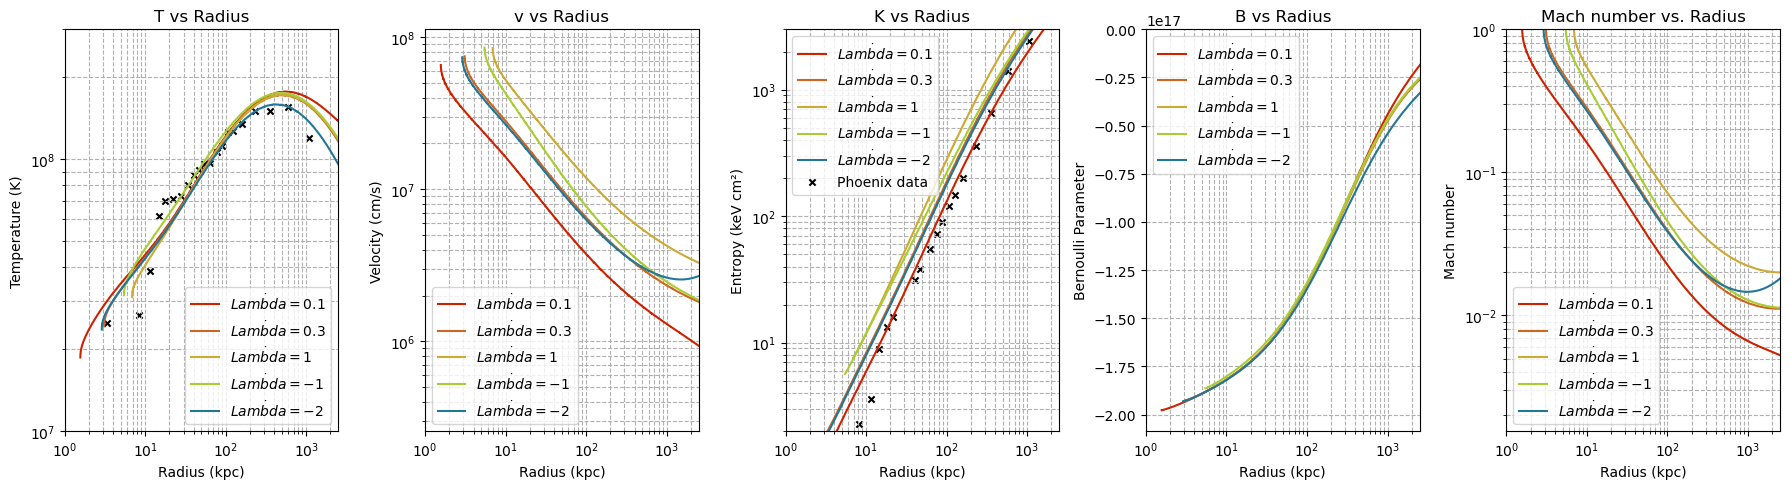

In [46]:
lambdatypes = [0.1, 0.3, 1, -1, -2]
colors     = ['#cc2200', "#cc6622", '#ccaa33', '#aacc33', "#227799"]
labels = [rf"$\dot{{Lambda}}={Lambda}$" for Lambda in lambdatypes]

results = []
for Lambdatype in lambdatypes:
    try:
        x, R0, v0, T0, recorder = BrentLooper(Mdot1 * 2700, 1 * ktc, 12 * ktc, Lambdatype)
        results.append((Lambdatype, recorder))
    except Exception as e:
        print(f"Failed for Λ={Lambdatype}: {e}")

# --- Create subplots ---
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharex=True)

for (Lambdatype, recorder), color, label in zip(results, colors, labels):
    r_kpc = np.array(recorder["ra2"]) / ktc
    T     = np.array(recorder["Tarray"])
    v     = np.array(recorder["varray"])
    rho   = np.array(recorder["rhoarray"])
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv
    Bern = np.array(recorder["Bern"])
    Mach = np.array(recorder["Mach"])

    axes[0].plot(r_kpc, T, color=color, label=label)
    axes[1].plot(r_kpc, v, color=color, label=label)
    axes[2].plot(r_kpc, K, color=color, label=label)
    axes[3].plot(r_kpc, Bern, color=color, label=label)
    axes[4].plot(r_kpc, Mach, color=color, label=label)

# --- Format each panel ---
for ax, ylabel, title in zip(
    axes,
    ['Temperature (K)', 'Velocity (cm/s)', 'Entropy (keV cm²)', 'Bernoulli Parameter', 'Mach number'],
    ['T vs Radius', 'v vs Radius', 'K vs Radius', 'B vs Radius', 'Mach number vs. Radius']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Radius (kpc)')
    ax.set_xlim(1, 2500)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which='both', ls='--')
    ax.legend()

axes[0].set_ylim(1e7, 3e8)
axes[0].scatter(Tmpx, Tmpy, s=20, marker='x', color='black', label='Phoenix data')
axes[2].scatter(x_values, y_values, s=20, marker='x', color='black', label='Phoenix data')
axes[2].legend()
axes[2].set_ylim(2, 3e3)
axes[3].set_yscale('linear')
axes[3].set_ylim(None, 0)
axes[4].set_ylim(None, 1)

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.3775, Rsonic = 15.0 Mdot = 31551.659718748462
x = 0.3968798828125, Rsonic = 2.6624562241189476 Mdot = 2126.919950814462
x = 0.41960937499999995, Rsonic = 4.417599182679155 Mdot = 4605.5177262332745
x = 0.4174560546875, Rsonic = 4.053259242891971 Mdot = 4047.4972523066735
x = 0.41769531249999997, Rsonic = 4.08166283956224 Mdot = 4089.1979529432588
x = 0.41769531249999997, Rsonic = 4.08288598386581 Mdot = 4091.24139385177
x = 0.41769531249999997, Rsonic = 4.08288598386581 Mdot = 4091.24139385177


C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\1165358681.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


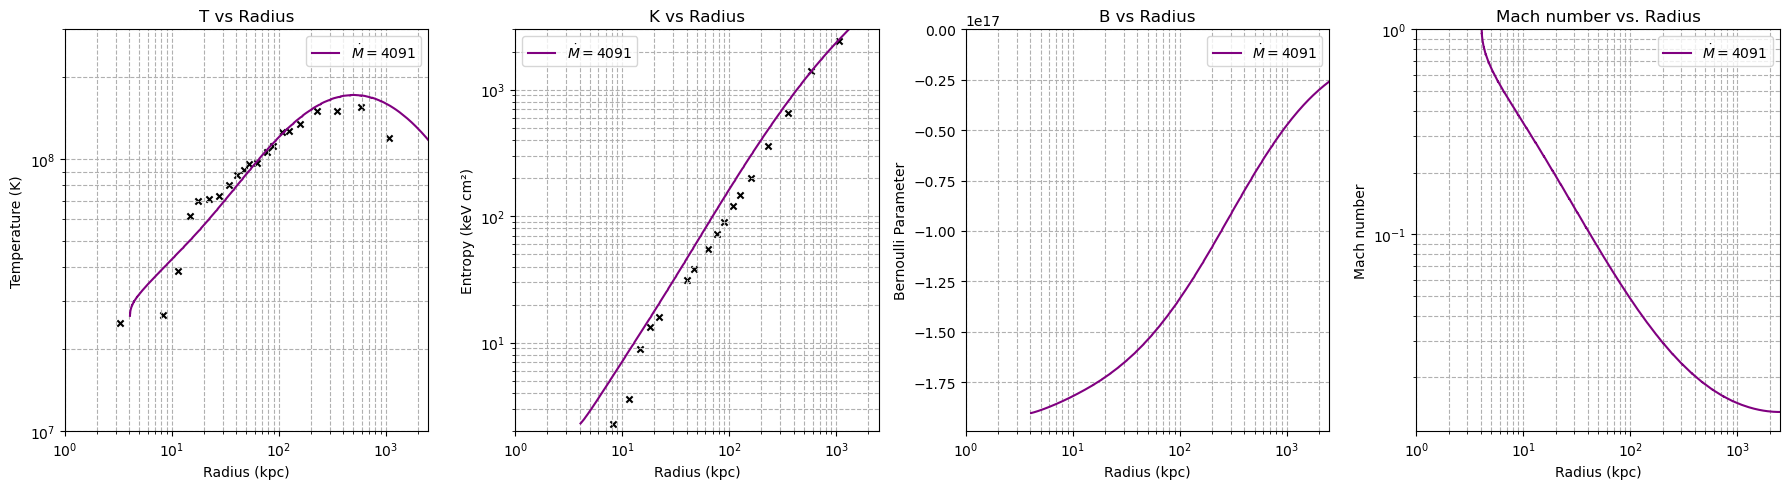

In [65]:
Mdotrange = [4091]
colors     = ['purple', 'crimson', 'tomato', 'darkorange', 'goldenrod']
labels = [rf"$\dot{{M}}={m}$" for m in Mdotrange]

results = []
for Mdot in Mdotrange:
    try:
        x, R0, v0, T0, recorder = BrentLooper(Mdot1 * Mdot, 1 * ktc, 15 * ktc, 0.3)
        results.append((Mdot, recorder))
    except Exception as e:
        print(f"Failed for Mdot={Mdot}: {e}")

# --- Create subplots ---
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True)

for (Mdot, recorder), color, label in zip(results, colors, labels):
    r_kpc = np.array(recorder["ra2"]) / ktc
    T     = np.array(recorder["Tarray"])
    rho   = np.array(recorder["rhoarray"])
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv
    Bern = np.array(recorder["Bern"])
    Mach = np.array(recorder["Mach"])

    axes[0].plot(r_kpc, T, color=color, label=label)
    axes[1].plot(r_kpc, K, color=color, label=label)
    axes[2].plot(r_kpc, Bern, color=color, label=label)
    axes[3].plot(r_kpc, Mach, color=color, label=label)

# --- Format each panel ---
for ax, ylabel, title in zip(axes, ['Temperature (K)', 'Entropy (keV cm²)', 'Bernoulli Parameter', 'Mach number'],
    ['T vs Radius', 'K vs Radius', 'B vs Radius', 'Mach number vs. Radius']):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Radius (kpc)')
    ax.set_xlim(1, 2500)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which='both', ls='--')
    ax.legend()

axes[0].set_ylim(1e7, 3e8)
axes[0].scatter(Tmpx, Tmpy, s=20, marker='x', color='black', label='Phoenix data')
axes[1].scatter(x_values, y_values, s=20, marker='x', color='black', label='Phoenix data')
axes[1].set_ylim(2, 3e3)
axes[2].set_yscale('linear')
axes[2].set_ylim(None, 0)
axes[3].set_ylim(None, 1)

plt.tight_layout()
plt.show()

In [48]:
y = np.log10(np.array([3324.598, 1522.680, 1553.475, 1297.309, 725.888, 594.173, 374.898, 346.043, 214.010, 193.623, 155.348, 137.762, 127.159, 112.765,
    96.075, 85.199, 78.642, 69.739, 57.085, 51.647, 39.811, 35.304, 33.246, 30.079, 16.830, 14.925, 14.055, 12.716, 9.607, 8.185,
    4.228, 3.008, 2.563, 1.975]))

y_pairs = y.reshape(-1, 2)

# Compute symmetric error for each pair
errors = np.abs(y_pairs[:, 0] - y_pairs[:, 1]) / 2
stdvi = errors**2

y_kvalues = np.log10(np.array([2413.28546, 1405.48459, 656.73673, 360.18178, 201.53377, 146.29093, 119.74596, 90.47357, 72.58879, 54.84417, 38.24800, 31.30777, 
    15.84893, 13.23546, 8.86801, 3.60182, 2.27259]))

In [63]:
def ChiSquaredCalc(Mdot, Lambdatype):
    x, R0, v0, T0, recorder = BrentLooper(Mdot*Mdot1, 0.1*ktc, 50*ktc, Lambdatype)
    rA = np.array(recorder["ra2"])
    TA = np.array(recorder["Tarray"])
    rhoA = np.array(recorder["rhoarray"])
    KA = (rhoA / (mu*mp_g))**(-2/3) * k_Bcgs * TA * etkv
    Kvals = []
    for j in range(len(x_values)):
        idx = np.argmin(np.abs(rA - x_values[j]*ktc))
        Kvals.append(np.log10(KA[idx]))
    sqdiff = (Kvals - y_kvalues)**2
    return sqdiff / stdvi

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.34400390625, Rsonic = 30.0 Mdot = 107453.84246156536
x = 0.36685302734374997, Rsonic = 1.7744834134339824 Mdot = 1105.7373443908377
x = 0.4174560546875, Rsonic = 4.050306109959496 Mdot = 4042.5690821208746
x = 0.40238281249999996, Rsonic = 2.912394761696739 Mdot = 2448.5808024806915
x = 0.411953125, Rsonic = 3.4813504358281175 Mdot = 3221.6117023739753
x = 0.4121923828124999, Rsonic = 3.501024639887574 Mdot = 3249.0302769129075
x = 0.4121923828124999, Rsonic = 3.50171961458282 Mdot = 3250.161406090145
x = 0.4121923828124999, Rsonic = 3.50171961458282 Mdot = 3250.161406090145
x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.34400390625, Rsonic = 30.0 Mdot = 107453.84246156536
x = 0.3672119140625, Rsonic = 1.7812551206762028 Mdot = 1112.4039956798351
x = 0.41769531249999997, Rsonic = 4.074809361110658 Mdot = 4077.7519991528375
x = 0.40274169921874997, Rsonic = 2.9280322408934305 Mdot = 2468.407768686125
x = 

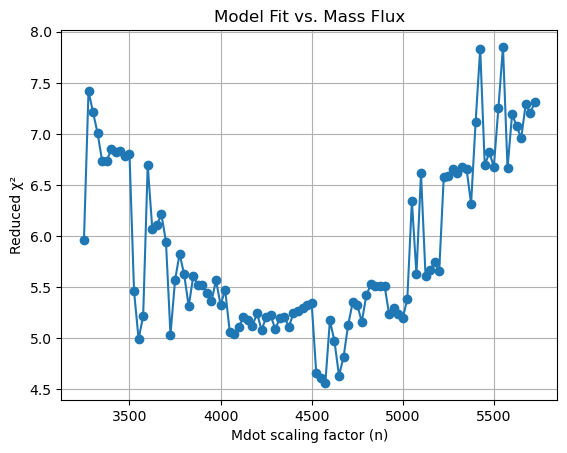

In [50]:
all_n = []
all_chi2 = []
for i in range(1, 101):
    n = i*25 + 3225
    results = ChiSquaredCalc(n, 0.3)
    chi2 = np.sum(results)
    all_n.append(n)
    all_chi2.append(chi2/16)

plt.plot(all_n, all_chi2, marker='o')
plt.xlabel("Mdot scaling factor (n)")
plt.ylabel("Reduced χ²")
plt.title("Model Fit vs. Mass Flux")
plt.grid(True)
plt.show()

In [ ]:
from scipy.optimize import differential_evolution

result = differential_evolution(lambda n: ChiSquaredCalc(n[0], 0.3).sum()/16, bounds=[(3200, 5800)], seed=42,
    strategy='rand1bin', popsize=15, tol=1e-2, disp=True, workers=1)

print(f"Best n: {result.x[0]:.2f}, reduced χ²: {result.fun:.4f}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.34400390625, Rsonic = 30.0 Mdot = 107453.84246156536
x = 0.38874511718750004, Rsonic = 2.363429642661051 Mdot = 1763.104094887291
x = 0.4215234375, Rsonic = 5.874775297414007 Mdot = 7039.063084911103
x = 0.4179345703124999, Rsonic = 4.119102470037529 Mdot = 4145.999084297936
x = 0.4212841796875, Rsonic = 4.894840831537651 Mdot = 5363.41765513606
x = 0.4215234375, Rsonic = 4.932219613892536 Mdot = 5419.252905102695
x = 0.4215234375, Rsonic = 4.9355757028242655 Mdot = 5424.9223615268975
x = 0.4215234375, Rsonic = 4.9355757028242655 Mdot = 5424.9223615268975
x = 0.315771484375, Rsonic = 1.0 Mdot = 390.73797887612886
x = 0.34400390625, Rsonic = 30.0 Mdot = 107453.84246156536
x = 0.38467773437499997, Rsonic = 2.2314114867825685 Mdot = 1607.7867262633824
x = 0.4217626953125, Rsonic = 5.493869496536131 Mdot = 6369.8210247823545
x = 0.4160205078125, Rsonic = 3.86264049165935 Mdot = 3763.6724237198896
x = 0.42056640624999997, Rson

In [ ]:
# Adjustable resolution
N_RES = 40

# Parameter ranges
M_vals = np.linspace(3000, 6000, N_RES)
Z_vals = np.linspace(0.3, 1.0, N_RES)

# Initialize 2D grid for reduced chi-squared values
chi2_grid = np.zeros((N_RES, N_RES))

# Evaluate ChiSquaredCalc at each (n, Z)
for i, n in enumerate(M_vals):
    for j, Z in enumerate(Z_vals):
        try:
            chi2 = ChiSquaredCalc(n, Z).sum() / 16
        except Exception as e:
            chi2 = np.nan
        chi2_grid[i, j] = chi2

plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(Z_vals, M_vals, chi2_grid, shading='auto', cmap='plasma')

plt.xlabel("Metallicity (Z)")
plt.ylabel("Mdot Scaling Factor (n)")
plt.title("Reduced χ² Across Mdot and Z")
cbar = plt.colorbar(pcm, label=r"$\chi^2_{\nu}$")
plt.grid(True, which='both', ls='--', lw=0.3)
plt.tight_layout()
plt.show()

min_idx = np.unravel_index(np.nanargmin(chi2_grid), chi2_grid.shape)
best_n = M_vals[min_idx[0]]
best_Z = Z_vals[min_idx[1]]
best_chi2 = chi2_grid[min_idx]

print(f"Best fit → Mdot: {best_n:.2f}, Z: {best_Z:.3f}, Reduced χ²: {best_chi2:.4f}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:9: RuntimeWarning: invalid value encountered in log10
  Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)


x = 0.276234130859375, Rsonic = 0.1 Mdot = 2.98252867398532
x = 0.345439453125, Rsonic = 50.0 Mdot = 264190.5555686816
x = 0.280660400390625, Rsonic = 0.6660795097145642 Mdot = 171.38473032874168
x = 0.402861328125, Rsonic = 10.072525318937007 Mdot = 16286.409955650252
x = 0.4217626953125, Rsonic = 5.369302414325786 Mdot = 6155.707562635545
x = 0.4045361328125, Rsonic = 3.017690962020175 Mdot = 2586.069448604761
x = 0.4102783203125, Rsonic = 3.359159544397785 Mdot = 3050.7076868397735
x = 0.40968017578125, Rsonic = 3.321893816965194 Mdot = 2999.659417433029
x = 0.40968017578125, Rsonic = 3.321893816965194 Mdot = 2999.659417433029
x = 0.276234130859375, Rsonic = 0.1 Mdot = 2.8141601198087174
x = 0.345439453125, Rsonic = 50.0 Mdot = 249276.57259302915
x = 0.28454833984375, Rsonic = 0.6999812188424746 Mdot = 179.40664753906574
x = 0.40238281249999996, Rsonic = 10.174566832713072 Mdot = 15612.748813957138
x = 0.4217626953125, Rsonic = 5.437274025777773 Mdot = 5918.344917427916
x = 0.405493

C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\3821932352.py:23: RuntimeWarning: invalid value encountered in sqrt
  mach = np.sqrt(v**2 / cs2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_37380\1374584586.py:6: RuntimeWarning: invalid value encountered in power
  KA = (rhoA / (mu*mp_g))**(-2/3) * k_Bcgs * TA * etkv


x = 0.276234130859375, Rsonic = 0.1 Mdot = 1.6776723791167287
x = 0.345439453125, Rsonic = 50.0 Mdot = 148607.1875073834
x = 0.32970825195312503, Rsonic = 1.158461475619893 Mdot = 292.1656056076043
x = 0.39568359374999995, Rsonic = 11.384482298059257 Mdot = 11193.69712555604
x = 0.42056640624999997, Rsonic = 6.271471886839575 Mdot = 4373.991695847412
x = 0.421044921875, Rsonic = 4.74308318983627 Mdot = 2877.1626171319776
x = 0.4215234375, Rsonic = 5.025600409854309 Mdot = 3137.2339365122452
x = 0.4215234375, Rsonic = 5.04340397840782 Mdot = 3154.2234058338795
x = 0.4215234375, Rsonic = 5.04340397840782 Mdot = 3154.2234058338795
x = 0.276234130859375, Rsonic = 0.1 Mdot = 1.6230504877036325
x = 0.345439453125, Rsonic = 50.0 Mdot = 143768.8139606308
x = 0.33251953125, Rsonic = 1.1941017339338518 Mdot = 299.20146744926194
x = 0.39520507812499994, Rsonic = 11.48089385579742 Mdot = 10977.012143263608
x = 0.42056640624999997, Rsonic = 6.337497794865636 Mdot = 4294.951857650224
x = 0.421284179

In [ ]:
# Best n val: 4091.58, chi^2 = 4.1441 (Z=0.3Zcirc)

Mdotpredx = [3.34829, 8.35576, 11.58323, 15.28964, 18.29833, 22.62611, 27.97747, 34.59450, 41.40200, 47.95690, 54.64981, 64.34438, 
    78.27391, 92.15927, 108.50781, 127.75649, 160.57346, 233.77299, 351.64083, 602.75642, 1085.07809]

Mdotpredy = [788.04628, 1697.79425, 2154.43469, 1838.09442, 2043.35972, 2525.21785, 3290.34456, 3562.24789, 3657.78682, 3562.24789, 
    3469.20437, 3290.34456, 3120.70613, 2882.50530, 2733.89361, 2525.21785, 2271.54759, 1653.44900, 1141.48777, 654.77480, 365.77868]

Mdotpredx = np.array(Mdotpredx)*ktc
Mdotpredy = np.array(Mdotpredy)
Mdot_obsarray = np.array(recorder["Mdotobsarray"])
Mdot_obsarray = (Mdot_obsarray * 60 * 60 * 24 * 365)/(1.988e33)

Mcool = np.array(recorder["Mcool"])
Mcool = (Mcool * 60 * 60 * 24 * 365) / (1.988e33)

plt.scatter(ra2, Mdot_obsarray, s=0.1, label='Observational Mdot')
plt.scatter(ra2, Mcool, s=0.1, label='Voit Mdot Approx.')
plt.scatter(Mdotpredx, Mdotpredy, s=4, label = 'Phoenix Mdot (Prediction)')
plt.xlabel('Radius (cm)')
plt.ylabel('Observational Mdot')
plt.xscale('log')
plt.yscale('log')
plt.title('Observational Mdot as a function of radius.')
plt.legend()
plt.xlim(0.5*ktc, 16000*ktc)
plt.ylim(0.1, 9000)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

KeyError: 'Mdotobsarray'